In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
sns.set(style='ticks', context='talk')


/Users/mikemull/anaconda/envs/hamilton/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Forecasting With The Kalman Filter

 - *Mike Mull*
 - @kwikstep
 - https://github.com/mikemull/

## TL;DL

- Who is Kalman and why is this a filter?
- The Kalman filter is a recursive algorithm
- The Kalman filter and state space models are strongly connected
- Many time series models can be put in state space form
- Applications: Navigation and control systems (spaceships, robots, touchpads), computer vision/image processing, trading strategies, econometrics

- Rudolf Kalman was an engineer, mathematician, and inventor.  He passed away on July 2, 2016
- The term filter hints at origins in signal processing/information theory.
- Applications in navigation, image processing, econometrics
- Lots of different terminology and approaches

## Notes

 - Using development version of StatsModels
 - There are two versions of Kalman filter in the statsmodels source
 - Using terminology and notation from Durbin and Koopman (_Time Series Analysis by State Space Methods_)

- the Kalman filter (and smoother in particular) can be used in AR models for parameter estimation

Suppose we have a time series defined like this:

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

Basically a random walk

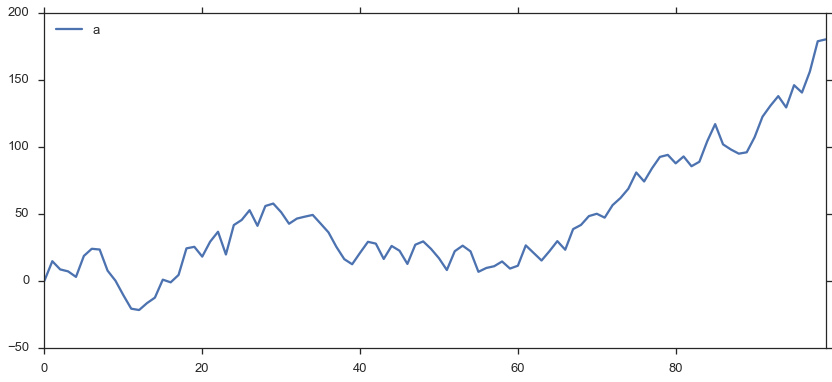

In [2]:
sigma_h = 10.0
h = np.random.normal(0, sigma_h, 110)
h[0] = 0.0
a = np.cumsum(h)

df = pd.DataFrame(a[0:100], columns=['a'])
_=df.plot(figsize=(14,6))

Now we introduce a second time series that's just the original series, plus some noise:

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


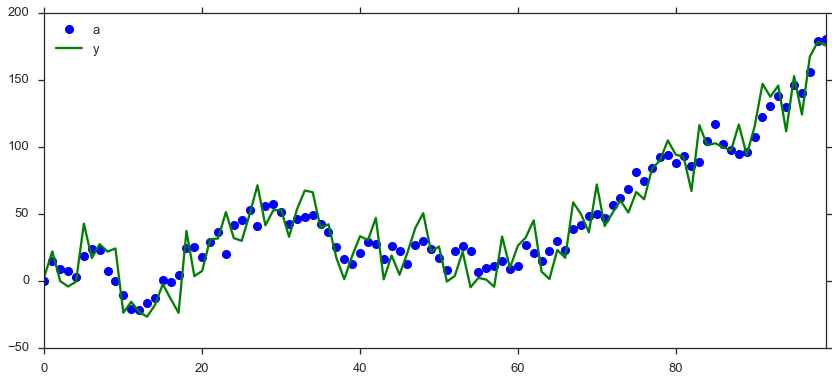

In [3]:
sigma_e = 15.
e = np.random.normal(0, sigma_e, 110)
df['y'] = a[0:100] + e[0:100]
_=df.plot(figsize=(14,6), style=['bo', 'g-',])

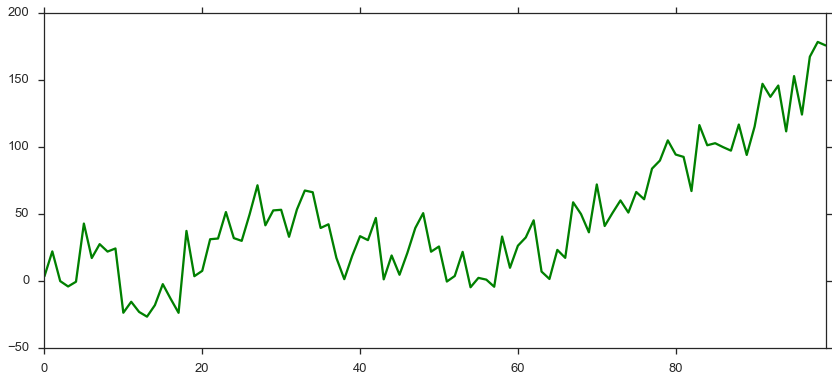

In [4]:
_=df.y.plot(figsize=(14,6), style=['g-',])

If we can only observe _y_, what can we say about &alpha;?

<img src='data/pydata_chicago/KalmanEstimation.png'>

- Filtering is estimating the state for the latest y_t (ie, removing the noise).
  - Ie, removing the noise
  - Nowcasting
- Smoothing/interpolation is estimating former states
  - Requires a forward filtering pass, and then a backward smoothing pass
- Prediction/forecasting is estimating the next state

## The Kalman Filter Recursion for this Model

$$
\begin{align}
v_t & = y_t - a_t &  F_t  & = P_t + \sigma^2_\epsilon \\
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$


## What We Know at Y<sub>t-1</sub>

- This conditional distribution:

$$
\begin{align}
p(\alpha_t | Y_{t-1}) & = N(a_t, P_t) \\
\end{align}
$$

- a<sub>t</sub> and P<sub>t</sub>
- The distribution of the forecast error, or _innovation_, v<sub>t</sub>.

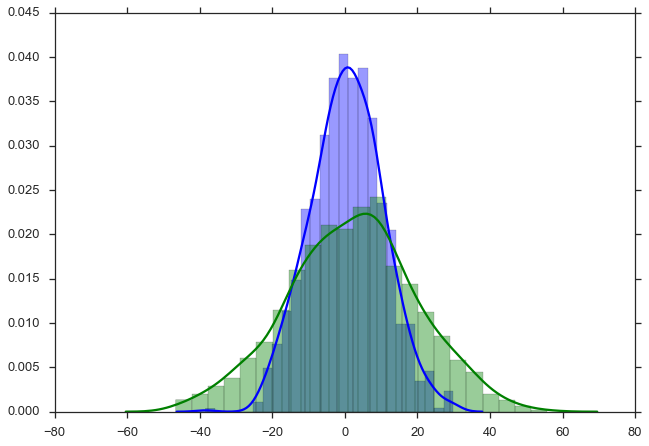

In [5]:
y_next = []
v_next = []
a_dist = np.random.normal(0, sigma_h, 1000)
a_1 = 0.
for i in range(1000):
    a_next = a_1 + np.random.normal(0, sigma_h)
    y_next.append(a_next + np.random.normal(0, sigma_e))
_=sns.distplot(a_dist, color='b', label='alpha')
_=sns.distplot(y_next, color='g', label='vt')

## What We Know at Y<sub>t</sub>

 - The latest observation, y<sub>t</sub>
 - v<sub>t</sub> = y<sub>t</sub> - a<sub>t</sub>
 
 
 ... also we know the relationship between &alpha;<sub>t</sub> and v<sub>t</sub>

## Regression Lemma

$$
\begin{align}
E \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} \mu_a \\ \mu_b \end{pmatrix},
Var \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} \sigma^2_a & \sigma_{ab} \\ \sigma_{ab} & \sigma^2_b \end{pmatrix}
\end{align}
$$

$$
\begin{align}
E(a|b) & = \mu_a + \frac{\sigma_{ab}}{\sigma_b^2}(b-\mu_b) &  Var(a|b) & = \sigma^2 - \frac{\sigma_{ab}}{\sigma_b^2}(b-\mu_b) \\
\end{align}
$$



- a and b are jointly distributed normal variables
- this lemma describes the conditional distribution of a given b
- normally used to explain least-squares regression in terms of conditional distributions


$$
\begin{align}
\sigma_{\alpha_t v_t} & = Cov(\alpha_t,v_t|Y_{t}) \\
& = E[(\alpha_t - a_t)(v_t - 0)] \\
& = E[(\alpha_t - a_t)(\alpha_t + \epsilon_t - a_t)] = P_t
\end{align}
$$

$$
\begin{align}
E(\alpha_t|v_t) & = a_t + \frac{P_t}{P_t + \sigma^2_\epsilon}(y_t-a_t) &  Var(\alpha_t|v_t) & = \frac{P_t}{P_t+\sigma^2_\epsilon} \\
\end{align}
$$

This ratio:
$$
K = \frac{P_t}{P_t + \sigma^2_\epsilon}
$$

is called the _Kalman gain_

- The covariance gives us the relationship between the observed variable and the state
- Since the noise in the observation is assumed to be independent of the variance in the state, the covariance is Pt
- If the noise in the observation is small, then the Kalman gain is near one and tells us to adjust our state to near the observation
- If the noise is large compared to variance in state, then we're better off staying near a_t

## Filtering


$$
\begin{align}
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
\end{align}
$$

$$
\begin{align}
p(\alpha_t | Y_t) & = N(a_{t|t}, P_{t|t}) \\
\end{align}
$$


$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t|t} & = E(\alpha_t|Y_t) \\
P_{t|t} & = Var(\alpha_t|Y_t) \\
\end{align}
$$


## Forecasting

$$
\begin{align}
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$

$$
\begin{align}
p(\alpha_{t+1} | Y_t) & = N(a_{t+1}, P_{t+1}) \\
\end{align}
$$

$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t+1} & = E(\alpha_{t+1}|Y_t) \\
P_{t+1} & = Var(\alpha_{t+1}|Y_t) \\
\end{align}
$$


## State Space Model for Our Example


### State Equation

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

### Observation (or Measurement) Equation

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


## State Space Models in General


### State Equation

$$
\begin{align}
\alpha_{t+1} & = T_t\alpha_{t} + R_t\eta_t  & \eta_t \sim N(0, Q_t) \\
\end{align}
$$

### Observation Equation

$$
\begin{align}
y_t & = Z_t\alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, H_t) \\
\end{align}
$$


- _T_ is transition matrix
- _Q_ is state covariance
- _Z_ is design matrix
- _H_ is observation covariance
- _R_ is selection matrix


## The Kalman Filter Recursion in General

$$
\begin{align}
v_t & = y_t - Z_T a_t &  F_t  & = Z_t P_t Z_t' + H_t \\
a_{t|t} & = a_t + P_t Z_t' F^{-1}_t v_t & P_{t|t} & = P_t - P_t Z_t' F^{-1}_t Z_t P_t \\
a_{t+1} & = T_t a_t + K_t v_t & P_{t+1} & = T_t P_t(T_t - K_t Z_t)' + R_t Q_t R_t'\\
\end{align}
$$


<img src='./data/pydata_chicago/StateSpaceClass.png'>

- This structure allows use of statsmodels time series framework and also allow custom state space models
- The Kalman smoother is the common technique for parameter estimation for AR models

In [6]:
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

kf = KalmanFilter(1,1)

kf.obs_cov = np.array([sigma_e]) # H
kf.state_cov = np.array([sigma_h])  # Q
kf.design = np.array([1.0])  # Z
kf.transition = np.array([1.0])  # T
kf.selection = np.array([1.0])  # R

ys, ah = kf.simulate(100)

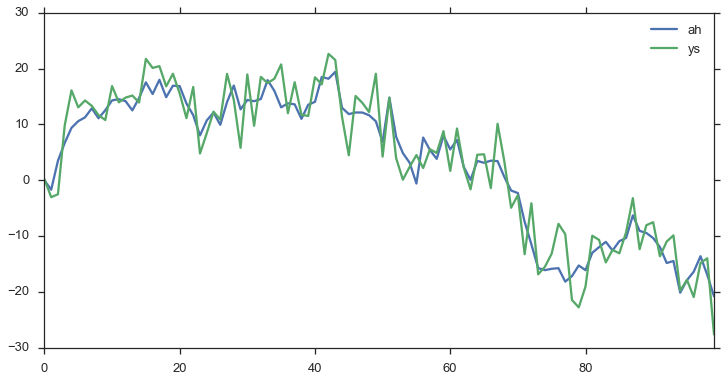

In [7]:
pd.DataFrame({'ys': ys.flatten(), 'ah': ah.flatten()}).plot(figsize=(12,6))

## Filtering

In [8]:
# Initialize known state
kf.initialize_known(np.array([0.0]), np.array([[sigma_h]]))
# Bind data
y = a + e
kf.bind(y.copy())
r = kf.filter()

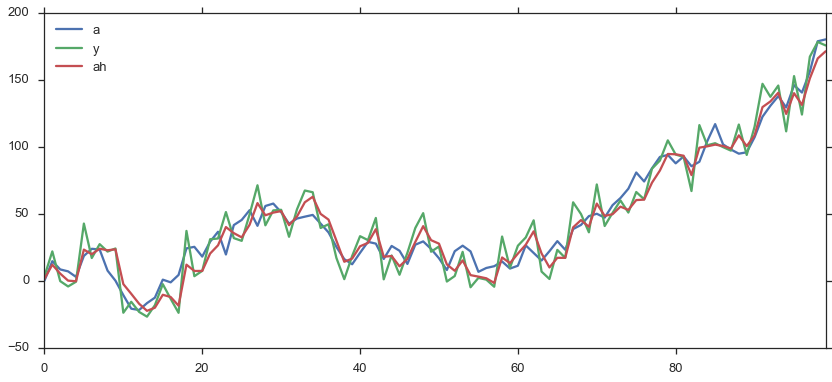

In [9]:
df['ah'] = r.predicted_state[0][1:101]
df.plot(figsize=(14,6))

## Forecasting

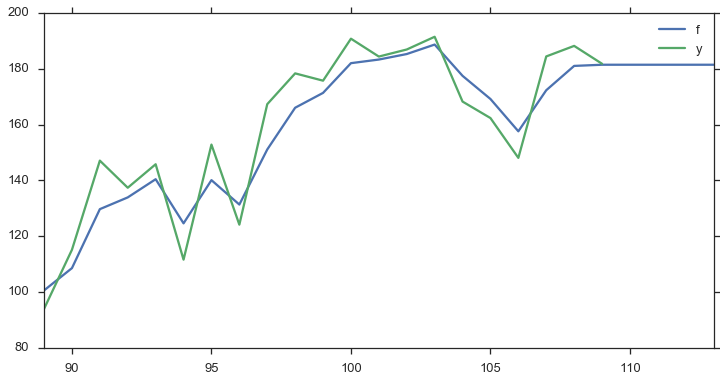

In [10]:
p = r.predict(90, 115, dynamic=20)
s_f = pd.Series(p.results.forecasts[0][1:])
s_y = pd.Series(y)
pd.DataFrame({'y':s_y, 'f':s_f}).iloc[-25:].plot(figsize=(12,6))

## Unobserved Components Models

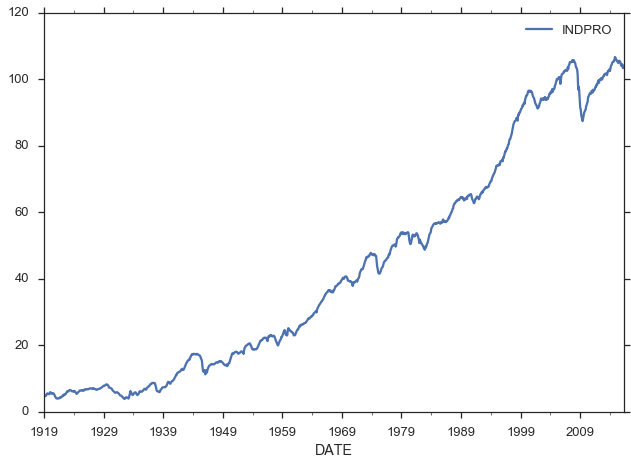

In [11]:
df_indpro = pd.read_csv('./data/pydata_chicago/INDPRO.csv', parse_dates=['DATE'])
df_indpro.set_index('DATE', inplace=True)
df_indpro.head()
_ =df_indpro.plot()

In [18]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

indpro_mod = UnobservedComponents(df_indpro.INDPRO,
                                  level=True,
                                  trend=True,
                                  stochastic_level=True,
                                  stochatist_trend=True)
indpro_res = indpro_mod.fit(method='powell', disp=False)
indpro_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Unobserved Components Results                           
==================================================================================
Dep. Variable:                     INDPRO   No. Observations:                 1170
Model:             random walk with drift   Log Likelihood                -614.607
Date:                    Mon, 22 Aug 2016   AIC                           1231.213
Time:                            19:49:30   BIC                           1236.278
Sample:                        01-01-1919   HQIC                          1233.124
                             - 06-01-2016                                         
Covariance Type:                      opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.1667      0.002     72.858      0.000       0.162       0.171
===================================================================================
Ljung-Box (Q):                      529.08   Jarque-Bera (JB):             14974.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.85   Skew:                            -1.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

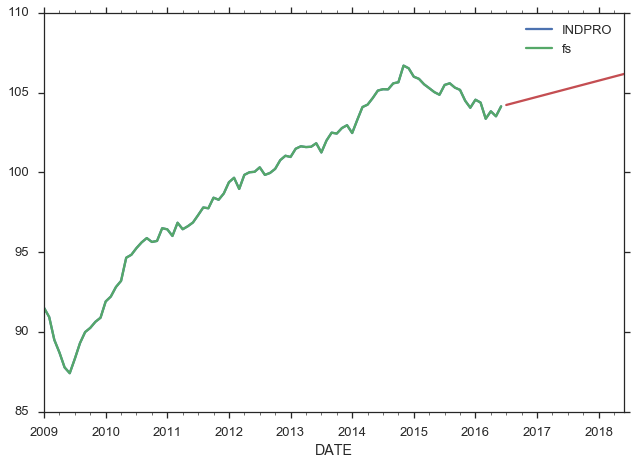

In [43]:
fres = indpro_res.get_forecast('2018-06-01')
df_indpro.ix['2009-01-01':].plot()
fres.predicted_mean.plot()


## Other State Space Models: AR(p)

### Normally (p=2)
$$
   y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t
$$

### State Space
$$
\begin{align}
   y_t & = \begin{bmatrix} 1 & 0 \end{bmatrix} \alpha_t \\
   \alpha_t & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \alpha_{t-1} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta_t
\end{align}
$$




Where

$$
   Z_t \equiv Z = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

and

$$
\begin{align}
   T_t \equiv T & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \\
   R_t \equiv R & = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
   \eta_t & \sim N(0, \sigma^2)
\end{align}
$$

## SARIMAX Model of Industrial Electricity Sales

In [44]:
df_esales = pd.read_csv('./data/pydata_chicago/esales.csv', parse_dates=['Month'])
df_esales.set_index('Month', inplace=True)
df_esales['petrol'] = df_esales.petrol.interpolate()
for v in ('coal', 'gas', 'petrol', 'elec'):
    df_esales['l'+v] = np.log(df_esales[v]).diff()
df_esales = df_esales.dropna()
df_esales.head()

,Usage,logUsage,coal,gas,petrol,elec,INDPRO,DlINDPRO,lcoal,lgas,lpetrol,lelec
Month,,,,,,,,,,,,
2008-02-01,81484.31279,11.308166,1.8742,8.6599,15.4001,6.34,105.0540,-0.003354,0.003849,0.040341,0.028520,0.001579
2008-03-01,83497.98014,11.332578,1.9133,9.2982,15.2342,6.46,104.7987,-0.002433,0.020648,0.071118,-0.010831,0.018751
2008-04-01,83695.60892,11.334942,1.9515,9.9365,15.0128,6.64,104.0207,-0.007451,0.019769,0.066394,-0.014640,0.027483
2008-05-01,87963.07225,11.384672,2.0244,10.6947,17.5884,6.75,103.4941,-0.005075,0.036675,0.073533,0.158336,0.016431
2008-06-01,87223.77170,11.376232,2.0688,12.0847,18.5929,7.35,103.3216,-0.001668,0.021695,0.122192,0.055540,0.085158


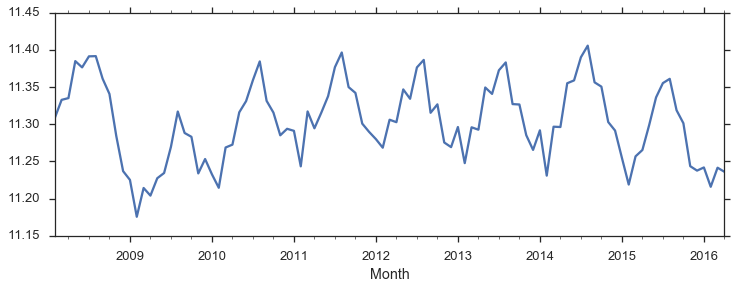

In [45]:
_=df_esales.logUsage.plot(figsize=(12,4))

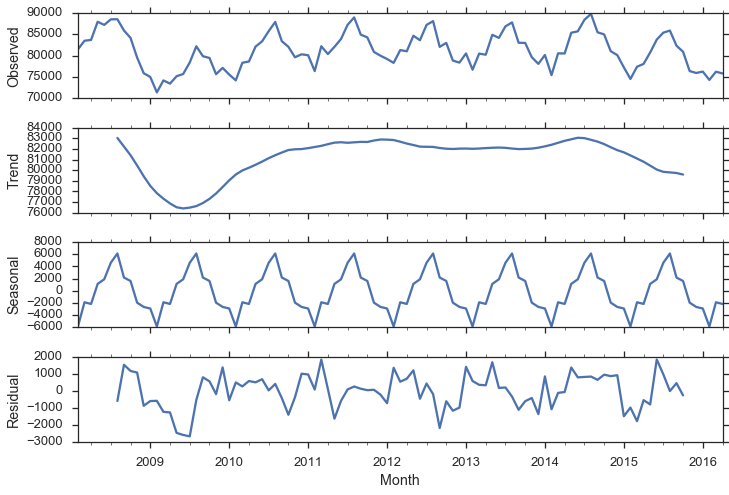

In [46]:

import statsmodels.tsa.api as smt
f=plt.figure(figsize=(12,6))
_=smt.seasonal_decompose(df_esales.Usage).plot()

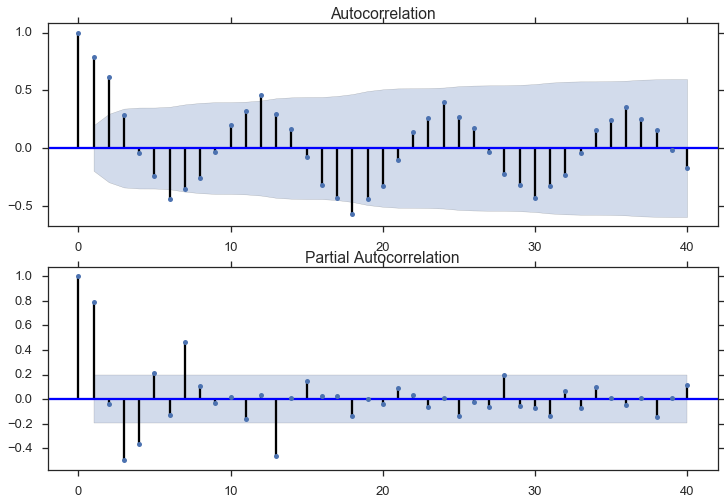

In [47]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smt.graphics.plot_acf(df_esales.logUsage.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = smt.graphics.plot_pacf(df_esales.logUsage.dropna(), lags=40, ax=ax2)

In [52]:
import statsmodels.api as sm
# Variables
endog = df_esales.logUsage
exog = sm.add_constant(df_esales[['lcoal', 'lgas', 'lpetrol', 'lelec', 'DlINDPRO']])
#exog = sm.add_constant(df_esales[['lcoal', 'lgas', 'lpetrol', 'lelec']])

# Fit the model
ar_mod = smt.statespace.SARIMAX(endog, order=(1,1,0), seasonal_order=(1,1,0,12))
ar_res = ar_mod.fit()
ar_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           logUsage   No. Observations:                   99
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 220.004
Date:                            Mon, 22 Aug 2016   AIC                           -434.008
Time:                                    20:10:53   BIC                           -426.223
Sample:                                02-01-2008   HQIC                          -430.858
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2074      0.140     -1.481      0.139      -0.482       0.067
ar.S.L12      -0.4231      0.106     -3.997      0.000      -0.631      -0.216
sigma2         0.0003   4.23e-05      8.063      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       33.62   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.75   Prob(JB):                         0.02
Heteroskedasticity (H):               0.74   Skew:                            -0.00
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

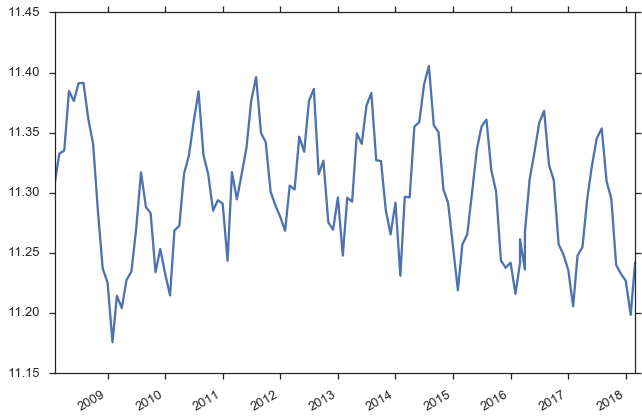

In [49]:
ar_p = ar_res.get_prediction('2016-03-01', '2018-03-01', dynamic=True)
pd.concat([df_esales.logUsage,ar_p.predicted_mean]).plot()

In [50]:
# Fit the model
arx_mod = smt.statespace.SARIMAX(endog, exog, order=(1,1,0), seasonal_order=(1,1,0,12))
arx_res = arx_mod.fit()
print(arx_res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           logUsage   No. Observations:                   99
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 223.584
Date:                            Mon, 22 Aug 2016   AIC                           -429.169
Time:                                    20:10:36   BIC                           -405.812
Sample:                                02-01-2008   HQIC                          -419.719
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.568e-09   3.89e-10      6.596      0.000    1.81e-09    3.33e-09
lcoal          0.0810      0.052   

/Users/mikemull/anaconda/envs/hamilton/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-macosx-10.6-x86_64.egg/statsmodels/base/model.py:489: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


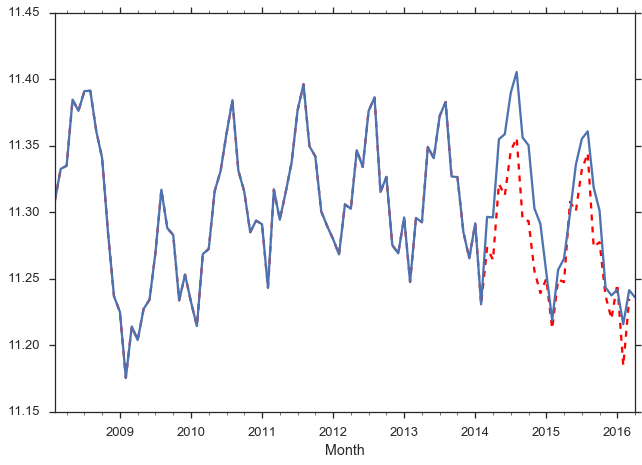

In [51]:
arx_p = arx_res.get_prediction('2014-03-01', '2016-03-01', dynamic=True)
fseries = pd.concat([df_esales.logUsage.ix[:'2014-02-01'],arx_p.predicted_mean])
fseries.plot(style='r--')
df_esales.logUsage.plot()

## Extensions and Variations of the Kalman Filter

- Extended Kalman filter
- "Unscented" Kalman filter (sigma point filter)
- Particle filters

## References

- Durbin and Koopman, Time Series Analysis by State-Space Methods
- [How Kalman Filters Work](http://www.anuncommonlab.com/articles/how-kalman-filters-work/)